# Renta Nacional

## Análisis de datos

Comenzamos con COTIZACIONES.

Cargamos los datos.

In [1]:
import pandas as pd
df = pd.read_excel("BBDD/COTIZACIONES.xlsx")
print(df.head())

  FECHA_COTIZACION TIPO_PENSION TIPO_COTIZACION  COTIZANTE  COTIZACION  \
0       2024-01-02            S               E  421008240           1   
1       2024-01-02            S               E  421008240           2   
2       2024-01-02            S               E  421008240           3   
3       2024-01-02            S               E  421008240           4   
4       2024-01-02           VA               E  421005868          11   

  TIPO_INTERMEDIARIO RUT_CORREDOR TIPO_RENTA  MESES_DIFERIDOS MODALIDAD_RENTA  \
0                  S   11370691-0          I                0               S   
1                  S   11370691-0          I                0               G   
2                  S   11370691-0          I                0               G   
3                  S   11370691-0          I                0               G   
4                  S   13982859-3          I                0               G   

   ...        VAN  TASA_VAN  DURATION  DIAS_VALIDEZ  INVALIDA  TIPO_

Vemos si existe alguna estacionalidad en la cantidad de cotizaciones.

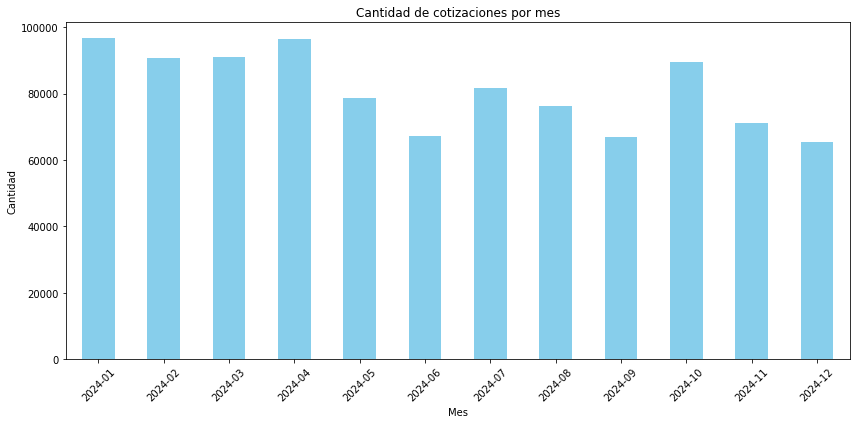

In [2]:
df["FECHA_COTIZACION"] = pd.to_datetime(df["FECHA_COTIZACION"])
df["MES"] = df["FECHA_COTIZACION"].dt.to_period("M")
conteo_mensual = df["MES"].value_counts().sort_index()

import matplotlib.pyplot as plt

conteo_mensual.plot(kind="bar", figsize=(12, 6), color="skyblue")
plt.title("Cantidad de cotizaciones por mes")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Seleccionamos 10.000 filas de manera aleatoria para disminuir la dificultad computacional.

In [1]:
df_muestra = df.sample(n=10000, random_state=42)  # random_state asegura reproducibilidad
df_muestra.to_excel("muestra_1000.xlsx", index=False)

NameError: name 'df' is not defined

## Modelamos la probabilidad de venta de la cotización.

Regresión logística.

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# Prepara la columna objetivo (1: aceptada, 0: no aceptada o -1)
df_muestra['ACEPTADA'] = df_muestra['ACEPTADA'].replace(-1, 1)

# Convertir FECHA_COTIZACION a datetime (lo hiciste tú ya)
df_muestra["FECHA_COTIZACION"] = pd.to_datetime(df_muestra["FECHA_COTIZACION"])
df_muestra["MES"] = df_muestra["FECHA_COTIZACION"].dt.month
df_muestra["DIA"] = df_muestra["FECHA_COTIZACION"].dt.day
df_muestra["DIA_SEMANA"] = df_muestra["FECHA_COTIZACION"].dt.weekday
df_muestra = df_muestra.drop(columns=["FECHA_COTIZACION", "FECHA_RESPUESTA", "FECHA_ACEPTACION"])

# Separar variables predictoras y target
X = df_muestra.drop(columns=["ACEPTADA"])
y = df_muestra["ACEPTADA"]

# Identificamos columnas
cols_numericas = X.select_dtypes(include='number').columns.tolist()
cols_categoricas = X.select_dtypes(include='object').columns.tolist()

# Preprocesamiento
preprocesador = ColumnTransformer([
    ("num", Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Imputamos con la media
        ('scaler', StandardScaler())  # Escalamos
    ]), cols_numericas),
    ("cat", Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputamos con la moda (más frecuente)
        ('onehot', OneHotEncoder(handle_unknown="ignore"))  # Codificamos categorías
    ]), cols_categoricas)
])

# Pipeline con regresión logística
pipeline = Pipeline(steps=[
    ("preprocesamiento", preprocesador),
    ("modelo", LogisticRegression(max_iter=1000))
])

# División en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento
pipeline.fit(X_train, y_train)

# Predicción de probabilidad de venta
y_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = pipeline.predict(X_test)

# Evaluación
print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

# Si quieres ver la probabilidad para un nuevo set de cotizaciones:
# proba_nuevas = pipeline.predict_proba(df_nuevas)[:, 1]


AUC: 0.9664160401002507
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1995
           1       0.50      0.20      0.29         5

    accuracy                           1.00      2000
   macro avg       0.75      0.60      0.64      2000
weighted avg       1.00      1.00      1.00      2000



In [13]:
from sklearn.metrics import accuracy_score

# Calcular el accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo: {accuracy:.4f}")


Accuracy del modelo: 0.9975


Accuracy muy alto, puede que haya alguna columna con muy alta correlación. Analizamos correlaciones.

ACEPTADA                       1.000000
TIT_MAXIMA                     0.096207
DIAS_VALIDEZ                   0.050072
PORCENTAJE_AUMENTO_TEMPORAL    0.042882
CAPITAL_NECESARIO              0.039159
MESES_AUMENTO_TEMPORAL         0.033011
TIT                            0.030491
PORCENTAJE_PERDIDA             0.027247
TASA_VENTA                     0.026822
MESES_GARANTIZADOS             0.024602
INVALIDA                       0.024210
PORCENTAJE_COMISION            0.015463
PERDIDA                        0.001341
RETIRO_EXCEDENTES             -0.004061
TASA_COSTO                    -0.006032
COTIZANTE                     -0.006295
VPP                           -0.012175
PRIMA_UNICA                   -0.012661
VAN                           -0.013450
TIPO_ERROR                    -0.014512
RENTA                         -0.016346
COTIZACION                    -0.017591
DURATION                      -0.018242
RETENCION_AFP                 -0.021413
CUOTA_MORTUORIA               -0.025498


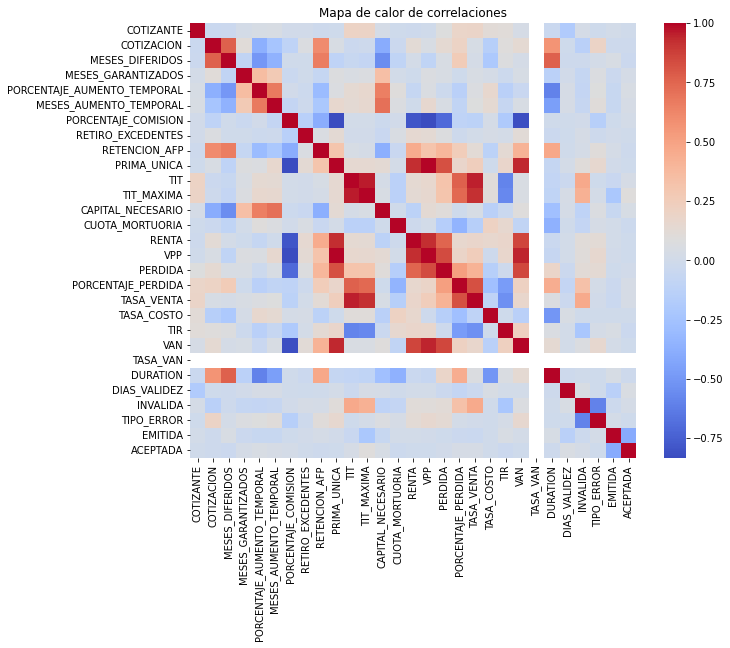

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir solo columnas numéricas
df_numerico = df_muestra.select_dtypes(include=["float64", "int64"])

# Incluir ACEPATADA si no está en las numéricas
df_numerico["ACEPTADA"] = df_muestra["ACEPTADA"]

# Calcular correlaciones con 'ACEPTADA'
correlaciones = df_numerico.corr(numeric_only=True)["ACEPTADA"].sort_values(ascending=False)
print(correlaciones)

# Visualizar el heatmap de correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(df_numerico.corr(), cmap="coolwarm", annot=False)
plt.title("Mapa de calor de correlaciones")
plt.show()
